# Week 4 BBC Classification Exercises

This assignment is based on a Kaggle coding competition (no longer active) that takes a BBC dataset of 2225 articles (1490 for training, 735 for testing). The training data is labeled with one of 5 categories: business, entertainment, politics, sport or tech. My challenge is to build a system that can accurately classify the testing data into these categories using matrix factorization and to compare that to a supervised learning method.

My plan of attack will be as follows (to be revised as appropriate):



1.   EDA
2.   Build Matrix Factorization Models
1.   Build Supervised Learning Model
2.   Discussion of Results





## Section 1: Exploratory Data Analysis

### Data Basics

We begin by doing our usual import statements of the necessary libraries to complete the analysis. These libraries are assumed to be installed in your environment already, but please do so before attempting to run the code. Please note that I have uploaded the Kaggle data to a google collab environment for my read_csv statement below but you may need to tailor it as appropriate for your environment.

Looking at the first few rows shows article id, long text, and a category (although the text is hard to read due to its length in this format). The info method is more insightful and shows what you would expect, although it's worth noting we are working with objects rather than strings here. I will focus the EDA on the training data to avoid leakage other than to confirm that both testing sets contain the same ID's so we can match text with label.

In [ ]:
pip install nltk

In [ ]:
# note i have added and subtraced many libraries here
# due to time constraints some of these can probably be deleted but this is a low priority given time constraints at the moment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import string
import seaborn as sns
import nltk
import itertools
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# read in new data
train = pd.read_csv('/content/BBC News Train.csv', index_col='ArticleId')
sample_sol = pd.read_csv('/content/BBC News Sample Solution.csv', index_col='ArticleId')
test = pd.read_csv('/content/BBC News Test.csv', index_col='ArticleId')

# Display the first few rows of the DataFrame (not particularly insightful given the textual nature)
#train.head()

# Display some basic info
#train.info()

In [ ]:
# Ensure NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Missing and Duplicate Values

While there don't appear to be any missing values, there are some duplicate values. The ID's differ, but the text is identical. Fortunately, they appear to have the same categorization as well, meaning that the same text appears with duplicate ID's but is still put into the same category. I would be more concerned if the same text had been encoded to different categories indicating some inherent inconsistency. My thanks to [JieShenDS2020 and his Kaggle notebook](https://www.kaggle.com/code/jieshends2020/matrix-factorization-97-acc-with-1-labels?scriptVersionId=165487232&cellId=18) for identifying this issue, as I would have missed it entirely due to the differing id numbers

In [ ]:
# Check for missing values
print(f'The number of missing values in each column are {train.isnull().sum().to_list()}.\n')

# get the number of rows before filtering out duplicates
print(f'There are currently {train.shape[0]} rows in the training data before any duplicates are removed.\n')

# Count the duplicated values in the 'Text' column
duplicated_text_count = train.duplicated(subset=['Text']).sum()

# Count the duplicated values based on both 'Text' and 'Category'
duplicated_textcat_count = train.duplicated(subset=['Text', 'Category']).sum()

# Print the counts
print(f'There are {duplicated_text_count} rows with the same texts in the training data.\n')
print(f'There are {duplicated_textcat_count} rows with the same texts and categories in the training data.\n')

# Count the occurrences in each category of train before dropping
train_counts = train['Category'].value_counts()

# Remove the duplicates from the frame
train = train.drop_duplicates(subset=['Text'])

# Check the number of rows in the train dataset
print(f'Samples in train after removing duplicates: {train.shape[0]}')

The number of missing values in each column are [0, 0].

There are currently 1490 rows in the training data before any duplicates are removed.

There are 50 rows with the same texts in the training data.

There are 50 rows with the same texts and categories in the training data.

Samples in train after removing duplicates: 1440


### Is the Data Balanced? Look at the Graphs

After removing the 50 duplicated articles, we still have 1440 entries that are distinct in our training set. Fortunately, removing these entires from our data set still leaves a fairly (although not perfectly) balanced data set. This is good since an unbalanced data set complicates classification (e.g. a model that seeks to diagnose a cancer that impacts 1% of the population can achieve 99% accuracy simply by saying "no" every time even though it is clinically useless)

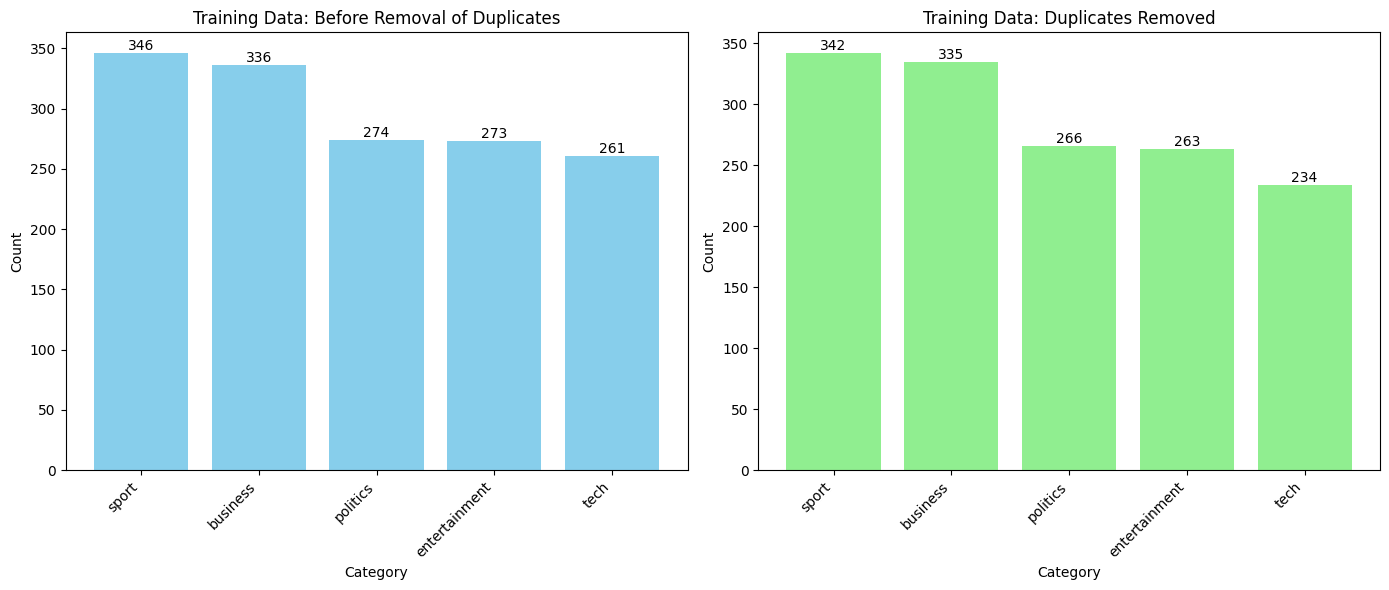

In [ ]:
filt_train_counts = train['Category'].value_counts()

# Create subplots: one row, two columns
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart for df_train
ax[0].bar(train_counts.index, train_counts.values, color='skyblue')
ax[0].set_title('Training Data: Before Removal of Duplicates')
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Count')
ax[0].set_xticks(range(len(train_counts.index)))
ax[0].set_xticklabels(train_counts.index, rotation=45, ha='right')

# Add labels on top of the bars for df_train
for i, count in enumerate(train_counts):
    ax[0].text(i, count, str(count), ha='center', va='bottom')

ax[1].bar(filt_train_counts.index, filt_train_counts.values, color='lightgreen')
ax[1].set_title('Training Data: Duplicates Removed')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Count')
ax[1].set_xticks(range(len(filt_train_counts.index)))
ax[1].set_xticklabels(filt_train_counts.index, rotation=45, ha='right')

# Add labels
for i, count in enumerate(filt_train_counts):
    ax[1].text(i, count, str(count), ha='center', va='bottom')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## Text EDA

We will now do some exploration of the text, but first we next to do some preprocessing, which includes the following:



1.   Convert all text to lowercase for consistency
2.   Remove punctuation (limited to no semantic value)
1.   Split and remove stop words
2.   Remove extra spaces
1.   Apply stemming (to handle similar semantic cases)
2.   Rejoin the words


In [ ]:
def text_preprocessing(df):
    """
    This function preprocesses the text data directly in the original data frame.

    We will save a copy for the EDA. Be careful since this is NOT returning a copy (by choice)

    The preprocessing steps include:

    1. Convert all text to lowercase to maintain consistency and avoid redundancy.
    2. Remove punctuation marks, as they generally do not contribute significant semantic value and can complicate analysis if treated as separate words.
    3. Tokenize the text into individual words and remove stopwords—common words such as articles and prepositions that appear frequently but carry little meaning.
    4. Remove any extra spaces that may have been introduced during the processing steps.
    5. Apply stemming to reduce each word to its root form, which helps in normalizing the text for analysis.
    6. Rejoin the words.

    The processed text is stored back into the 'Text' column of the DataFrame.
    """
    # convert to lower cases
    df['Text']=df['Text'].str.lower()

    # remove punctuation
    df['Text'] = df['Text'].apply(lambda doc: re.sub(r'[^\w\s]+', '', doc))

    # remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    df['Text'] = df['Text'].apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop_words)]))

    # remove extra spaces
    df['Text'] = df['Text'].apply(lambda doc: re.sub(' +', ' ', doc))

    # stemming
    porter_stemmer = PorterStemmer()
    df['Text'] = df['Text'].apply(lambda doc:  [porter_stemmer.stem(word) for word in word_tokenize(doc) ])
    df['Text'] = df['Text'].apply(lambda words: ' '.join(words))

# copy of training data so we avoid any accidents
train_eda = train.copy()
text_preprocessing(train_eda)

### Word Frequency Plots

The function get_common_words below gives us the (default 20) most common words for a series, which we can use for all the data or a particular category subset. We use this to look at the most common words across all the articles or by group, and graphically we notice that even after filtering out the stopwords, some commonalities such as "**said**" and "**would**" remain. This suggests some additional filtering maybe be useful in our model. That said, some distinctions are also obvious such as "**music**" and "**awards**" in entertainment but "**minister**" and "**government**" in politics, which suggests that these unique words will be criticial in distinguishing the content of these articles.

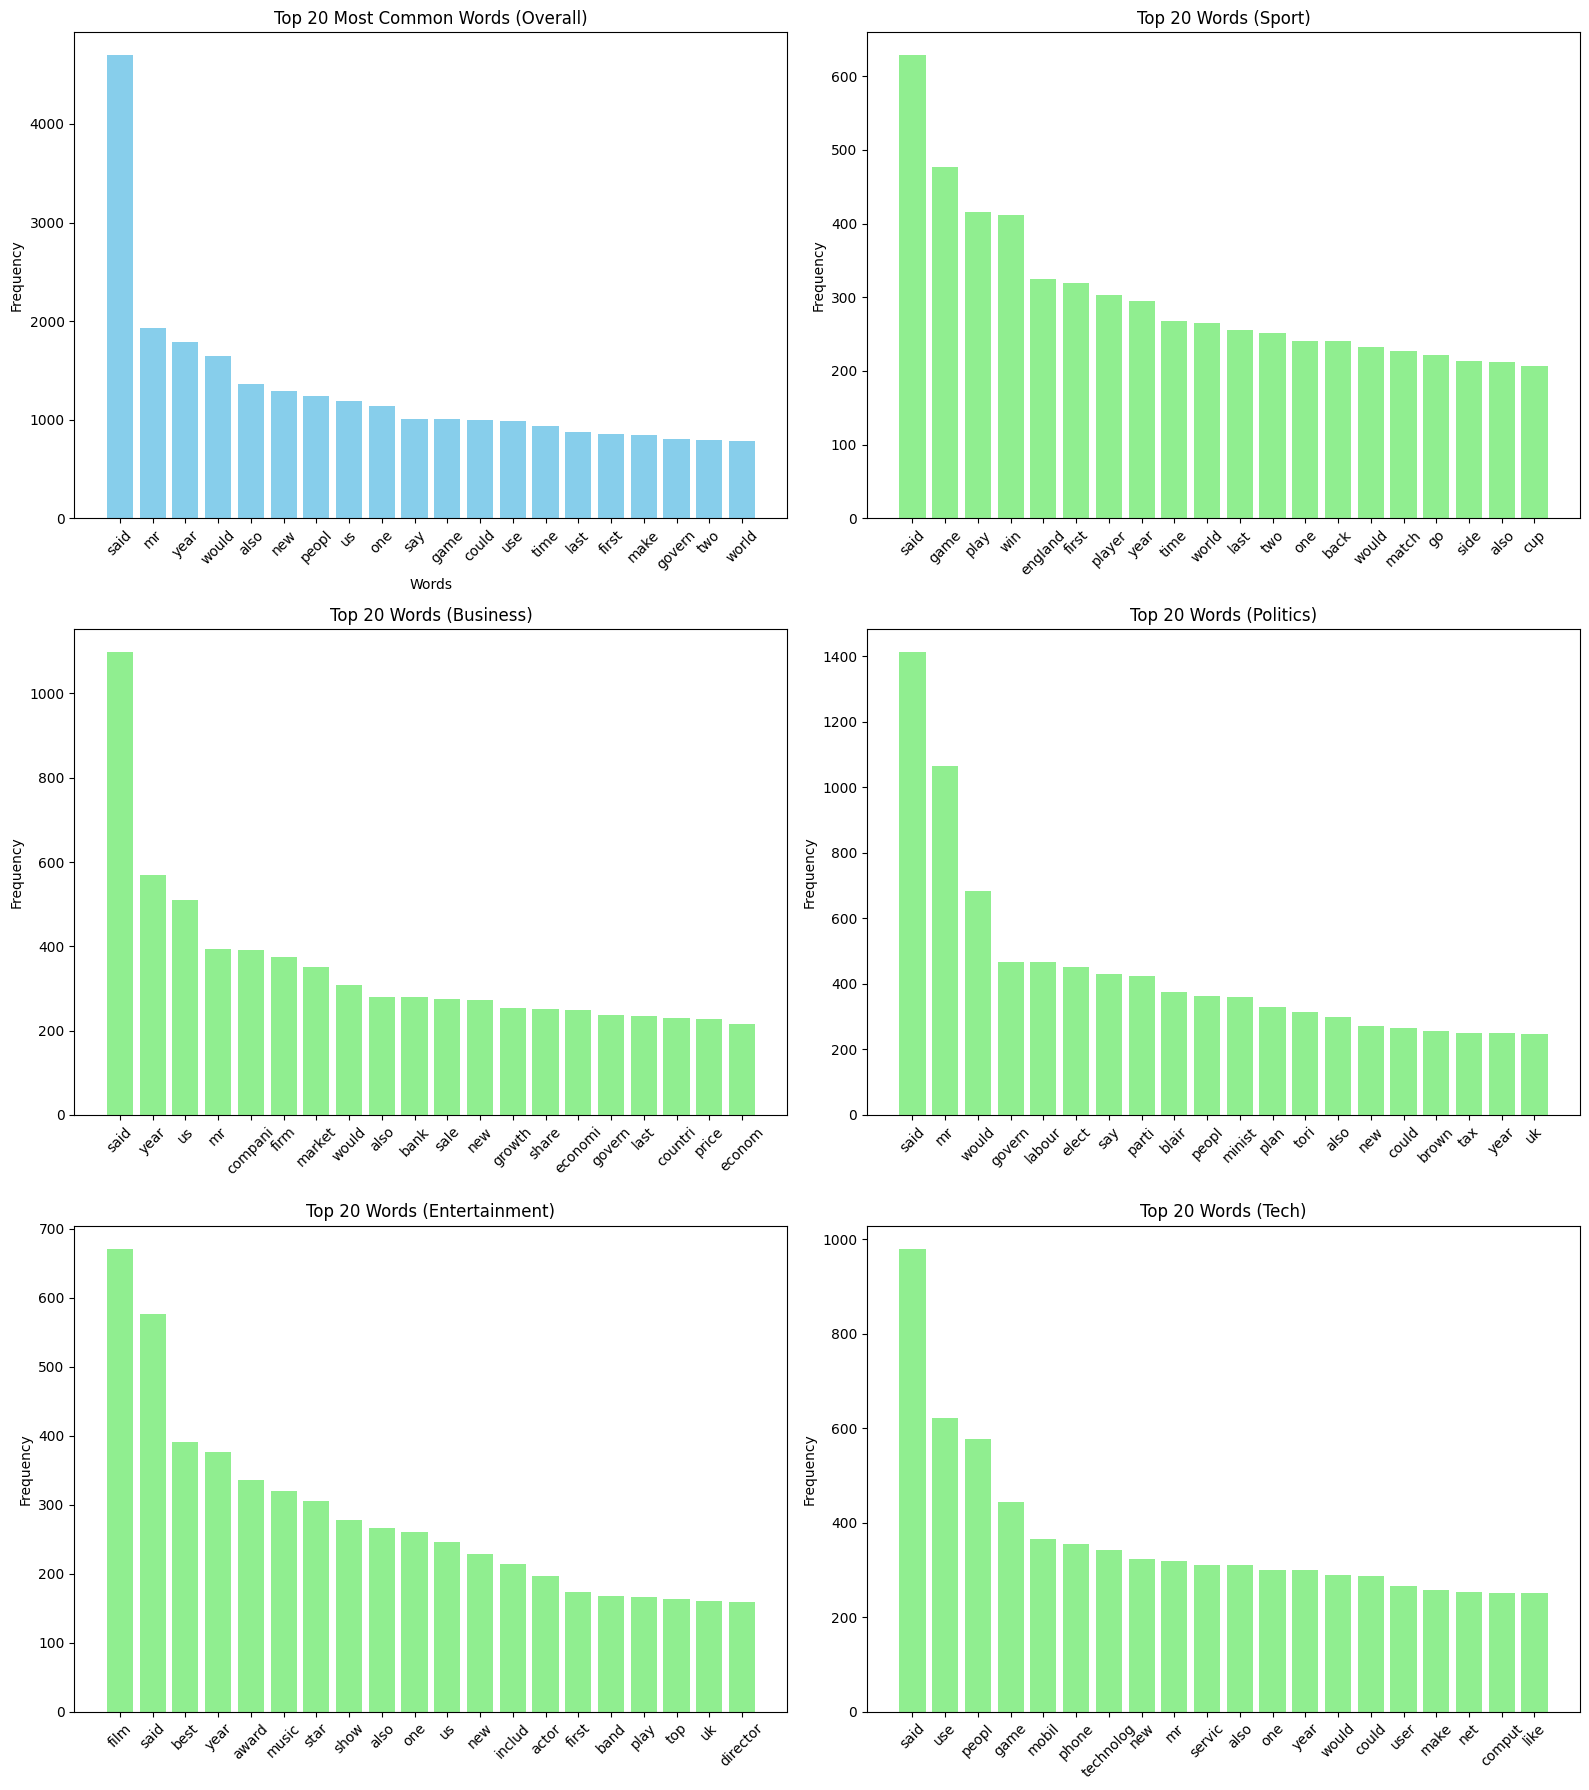

In [ ]:
# Function to calculate the most common words
def get_common_words(text_series, num_words=20):
    all_words = ' '.join(text_series).split()
    word_counts = Counter(all_words)
    common_words = word_counts.most_common(num_words)
    return zip(*common_words)  # Separates words and counts

# Get common words for overall dataset
overall_words, overall_counts = get_common_words(train_eda['Text'])

# Get common words for each category
categories = ['sport', 'business', 'politics', 'entertainment', 'tech']
category_common_words = {}
for category in categories:
    category_text = train_eda[train_eda['Category'] == category]['Text']
    category_common_words[category] = get_common_words(category_text)

fig, axes = plt.subplots(3, 2, figsize=(16, 18))  # 3 rows, 2 columns

# Plot overall most common words
axes[0, 0].bar(overall_words, overall_counts, color='skyblue')
axes[0, 0].set_title('Top 20 Most Common Words (Overall)')
axes[0, 0].set_xlabel('Words')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot most common words for each category
for idx, category in enumerate(categories):
    words, counts = category_common_words[category]
    row = (idx + 1) // 2
    col = (idx + 1) % 2
    axes[row, col].bar(words, counts, color='lightgreen')
    axes[row, col].set_title(f'Top 20 Words ({category.capitalize()})')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

### Word Length Visuals

Word length also appears to vary by category, so we need to be mindful of that as well. We should be sure to normalize here as well to avoid biasing our results.

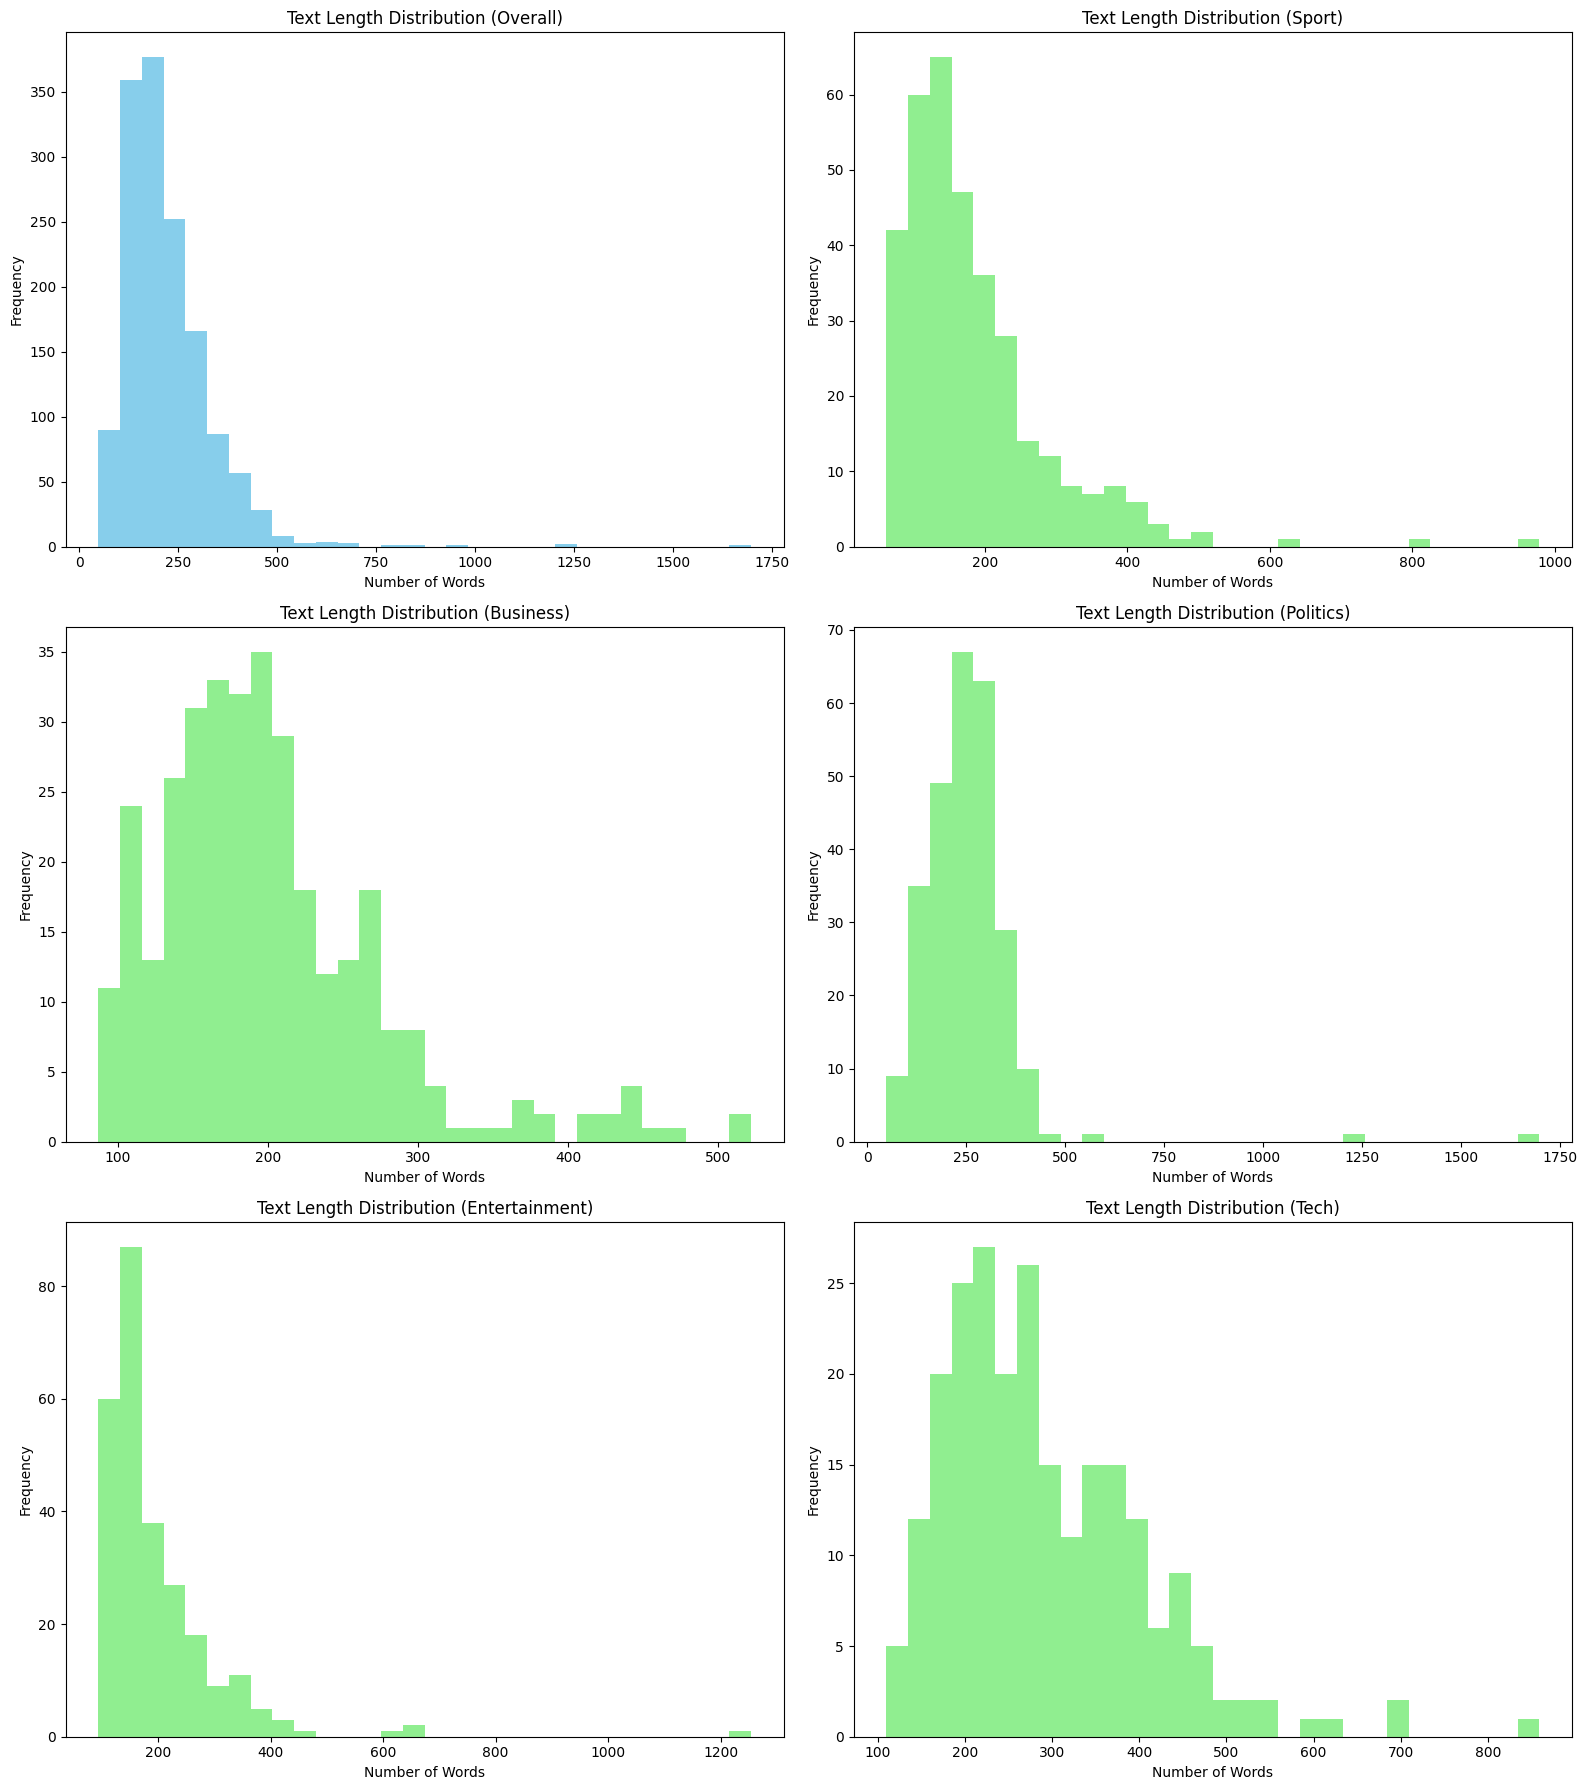

In [ ]:
# Calculate the length of each document in the 'Processed_Text' column
train_eda.loc[:, 'Text_Length'] = train_eda['Text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(3, 2, figsize=(16, 18))  # 3 rows, 2 columns

# Plot overall text length distribution
axes[0, 0].hist(train_eda['Text_Length'], bins=30, color='skyblue')
axes[0, 0].set_title('Text Length Distribution (Overall)')
axes[0, 0].set_xlabel('Number of Words')
axes[0, 0].set_ylabel('Frequency')

# Plot text length distribution for each category
for idx, category in enumerate(categories):
    category_lengths = train_eda[train_eda['Category'] == category]['Text_Length']
    row = (idx + 1) // 2
    col = (idx + 1) % 2
    axes[row, col].hist(category_lengths, bins=30, color='lightgreen')
    axes[row, col].set_title(f'Text Length Distribution ({category.capitalize()})')
    axes[row, col].set_xlabel('Number of Words')
    axes[row, col].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

## Part 2 Matrix Factorization Models

Please note: this section relies heavily on the example notes in Part 2.2 Model trainings and predictions from [JieShenDS2020 and his Kaggle notebook](https://www.kaggle.com/code/jieshends2020/matrix-factorization-97-acc-with-1-labels?scriptVersionId=165487232&cellId=18). I am grateful to their example and have had to rely on their precedence as I have not worked with NLP before.

Note that they chose to do a train test split rather than focus on the test.

To answer Q1, we make sure to avoid including the test data in the training set to avoid data leakage.

While my training accuracy is excellent, my testing accuracy is appallingly low (below what I would expect from random chance). This suggests significant overfitting or an error in the code. I'm struggling to identify the problem, but I welcome suggestions for how to fix this. I understand if this impacts my grade - I just want to figure this one out.

The text processing method is TF-IDF. TF is text frequency showing how often a word appears in a document. Note that we generally exclude certain filler words such as definite articles and other common words with little distinctive value. We also normalize by length since a word that appears 15 times in a 2000 word article is differnt from one that appears 15 times in a 230 word article. IDF is the log of the number of documents divided by the number of documents containing the word. So if there are 1000 documents and 600 contain the word then IDF is log(1000/600). I am using this method since it is simple and was recommended in the [cloud.google.com resource](https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification) we were provided as a good starting point for NLP newbies like myself.

Non-negative matrix factorization is being used since all the values are positve, which works well with textual analysis (which is logically bounded between 0 and 1). I have chosen values that I think are reasonable but have deferred to many of the choices in the example Kaggle notebook I listed earlier as I do not have much experience here. These appear to be fairly standard, but I welcome any feedback on these.

In [ ]:
# Label Permutation
def predict(df, yp, n_labels=5):
    yt = df['Category']

    yp = np.argmax(yp[:, :n_labels], axis=1)  # Only consider the top `n_labels` components

    best_accuracy = float('-inf')
    best_permutation = ()
    best_label_mapping_yp = {}
    best_ypred = []
    permutations = list(itertools.permutations(np.arange(n_labels)))
    unique_labels = yt.unique()
    label_mapping_yt = {i: label for i, label in enumerate(unique_labels)}

    for permutation in permutations:
        label_mapping_yp = {perm: label_mapping_yt[i] for i, perm in enumerate(list(permutation))}
        yp_gt = [label_mapping_yp[y] for y in yp]
        accuracy = (yt == yp_gt).sum() / len(yt)
        if accuracy > best_accuracy:
            best_permutation = permutation
            best_accuracy = accuracy
            best_ypred = yp_gt
            best_label_mapping_yp = label_mapping_yp

    return (best_ypred, best_label_mapping_yp, best_accuracy)

# Model training and testing
def MF_training(train_data, test_data, min_df=2, max_df=0.9, norm='l2', stop_words=['said'], ngram_range=(1, 2), l1_ratio=0.0, n_components=5):
    # Preprocess the training data
    text_preprocessing(train_data)

    # Train the TFIDF and NMF models on the entire training data
    tfidf = TfidfVectorizer(min_df=min_df, max_df=max_df, norm=norm, stop_words=stop_words, ngram_range=ngram_range)
    tfidf_train = tfidf.fit_transform(train_data['Text'])

    nmf = NMF(n_components=n_components, init='nndsvda', solver='mu', beta_loss='kullback-leibler', l1_ratio=l1_ratio, random_state=1)
    nmf_train = nmf.fit_transform(tfidf_train)

    # Map NMF outputs to the correct labels using label permutation
    y_pred_train_labeled_data, label_mapping_yp, labeled_data_accuracy = predict(train_data, nmf_train)

    print(f'Training accuracy on the labeled data: {labeled_data_accuracy}')

    # Preprocess the test data
    text_preprocessing(test_data)

    # Apply the trained TFIDF and NMF models to the test data
    tfidf_test = tfidf.transform(test_data['Text'])
    nmf_test = nmf.transform(tfidf_test)
    y_pred_test = np.argmax(nmf_test, axis=1)
    y_pred_test = [label_mapping_yp[y] for y in y_pred_test]

    return y_pred_train_labeled_data, y_pred_test, labeled_data_accuracy, tfidf, nmf, label_mapping_yp

# Apply the training process and predict on the test set
_, y_pred_test, train_accuracy, tfidf, nmf, label_mapping_yp = MF_training(train, test, n_components=5)

# Evaluate the model on the provided test set
sample_sol['Predicted'] = y_pred_test
test_accuracy = accuracy_score(sample_sol['Category'], sample_sol['Predicted'])
print(f'Test set accuracy: {test_accuracy}\n')

# Confusion matrix
confusion_matrix(sample_sol['Category'], sample_sol['Predicted'])

Training accuracy on the labeled data: 0.9479166666666666
Test set accuracy: 0.18775510204081633



array([[33, 22, 27, 37, 28],
       [32, 22, 36, 30, 27],
       [28, 27, 24, 37, 31],
       [38, 18, 25, 34, 32],
       [31, 23, 38, 30, 25]])

## Trying a new way to fail

Since the first method left a lot to be desired, a tried a different method which.... also left a lot to be desired. I don't see any stupid mistakes, but that's probably why I'm getting an accuracy on par with random chance. I'll sensitize the results to see if something improves this mess.

In [ ]:
# Ensure test_data and sample_solution are aligned by ArticleId
td = test.join(sample_sol, on='ArticleId')

# Preprocess the text data directly by calling the text_preprocessing function
text_preprocessing(train)
text_preprocessing(td)

# Extract the text and labels
X_train = train['Text']
y_train = train['Category']
X_test = td['Text']
y_test = td['Category']

# Preprocess the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Apply TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Apply NMF for dimensionality reduction
nmf_model = NMF(n_components=10, random_state=42)
W_train = nmf_model.fit_transform(X_train_tfidf)
W_test = nmf_model.transform(X_test_tfidf)

# Matching NMF components directly to labels
num_categories = len(set(y_train_encoded))
category_means = np.zeros((num_categories, 10))  # Adjust dimensions here
for i in range(num_categories):
    category_means[i] = np.mean(W_train[y_train_encoded == i], axis=0)

# Predict labels based on maximum similarity to category means
train_pred_labels = np.argmax(np.dot(W_train, category_means.T), axis=1)
test_pred_labels = np.argmax(np.dot(W_test, category_means.T), axis=1)

# Calculate accuracy
train_accuracy = accuracy_score(y_train_encoded, train_pred_labels)
test_accuracy = accuracy_score(y_test_encoded, test_pred_labels)

# Output results
print(f'Training accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, test_pred_labels)
print(f'Confusion Matrix:\n{conf_matrix}')

Training accuracy: 0.8618055555555556
Test accuracy: 0.19183673469387755
Confusion Matrix:
[[24 21 36 39 27]
 [18 23 49 28 29]
 [20 26 36 37 28]
 [21 18 41 34 33]
 [21 24 48 30 24]]


## Sensitivity Analysis

Now we look at changing the number of components in the model to see if that improves our results. Unfortunately, the story seems consistent. Either I'm not accurately capturing something here or this model is not well-suited for this particular task. The latter is possible, but Occam's razor suggests the former.

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


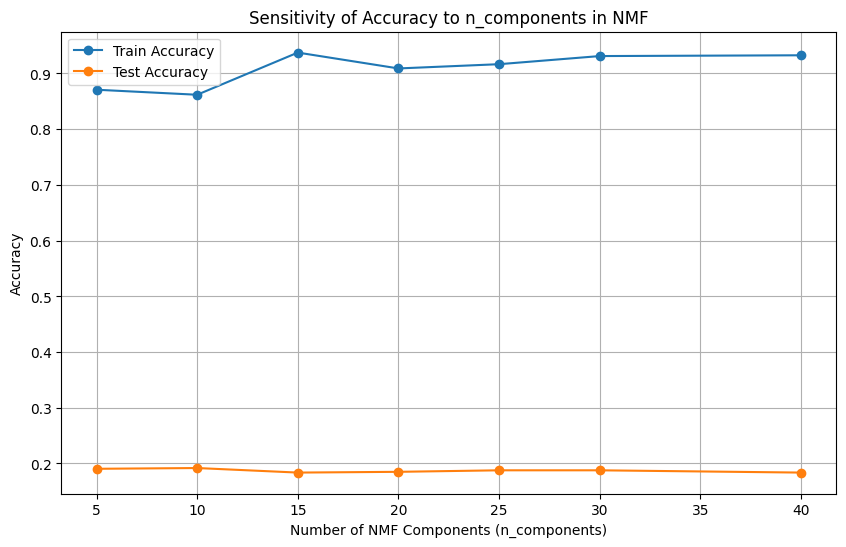

In [ ]:
# Define a range of n_components to test
n_components_range = [5, 10, 15, 20, 25, 30, 40]
train_accuracies = []
test_accuracies = []

for n_components in n_components_range:
    # Apply NMF for dimensionality reduction
    nmf_model = NMF(n_components=n_components, random_state=42)
    W_train = nmf_model.fit_transform(X_train_tfidf)
    W_test = nmf_model.transform(X_test_tfidf)

    # Matching NMF components directly to labels
    num_categories = len(set(y_train_encoded))
    category_means = np.zeros((num_categories, n_components))
    for i in range(num_categories):
        category_means[i] = np.mean(W_train[y_train_encoded == i], axis=0)

    # Predict labels based on maximum similarity to category means
    train_pred_labels = np.argmax(np.dot(W_train, category_means.T), axis=1)
    test_pred_labels = np.argmax(np.dot(W_test, category_means.T), axis=1)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train_encoded, train_pred_labels)
    test_accuracy = accuracy_score(y_test_encoded, test_pred_labels)

    # Store the results
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Create a DataFrame to display the results
results_df = pd.DataFrame({'n_components': n_components_range,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies
})

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(n_components_range, test_accuracies, label='Test Accuracy', marker='o')
plt.title('Sensitivity of Accuracy to n_components in NMF')
plt.xlabel('Number of NMF Components (n_components)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Part 3 Comparison with Supervised Learning

In [ ]:
# X_train_tfidf and y_train_encoded are already prepared
# Initialize models
logreg = LogisticRegression(random_state=42, max_iter=1000)
rf = RandomForestClassifier(random_state=42, n_estimators=100)

# Train models
logreg.fit(X_train_tfidf, y_train_encoded)
rf.fit(X_train_tfidf, y_train_encoded)

# Predict on test data
logreg_preds = logreg.predict(X_test_tfidf)
rf_preds = rf.predict(X_test_tfidf)

# Calculate accuracy
logreg_accuracy = accuracy_score(y_test_encoded, logreg_preds)
rf_accuracy = accuracy_score(y_test_encoded, rf_preds)

print(f"Logistic Regression Test Accuracy: {logreg_accuracy}")
print(f"Random Forest Test Accuracy: {rf_accuracy}\n")

# Confusion matrices
logreg_conf_matrix = confusion_matrix(y_test_encoded, logreg_preds)
rf_conf_matrix = confusion_matrix(y_test_encoded, rf_preds)

print(f"Logistic Regression Confusion Matrix:\n{logreg_conf_matrix}\n")
print(f"Random Forest Confusion Matrix:\n{rf_conf_matrix}")

Logistic Regression Test Accuracy: 0.19183673469387755
Random Forest Test Accuracy: 0.1891156462585034

Logistic Regression Confusion Matrix:
[[36 22 23 37 29]
 [37 23 33 30 24]
 [30 28 24 36 29]
 [40 17 25 34 31]
 [34 24 36 29 24]]

Random Forest Confusion Matrix:
[[37 21 23 39 27]
 [38 22 31 29 27]
 [32 27 22 37 29]
 [40 19 26 34 28]
 [36 22 36 29 24]]


### Comparison with the unsupervised approach

Our instructions were to "Include only 10%, 20%, 50% of labels, and observe train/test performance changes."

I'm a little confused why, since before I was not using a train/test split on the training data but was using separate training and test files.

I honestly don't think this is particularly insightful, but the results are roughtly the same. The classification results seem to be very haphazard at best, suggesting difficulty in classifying the results

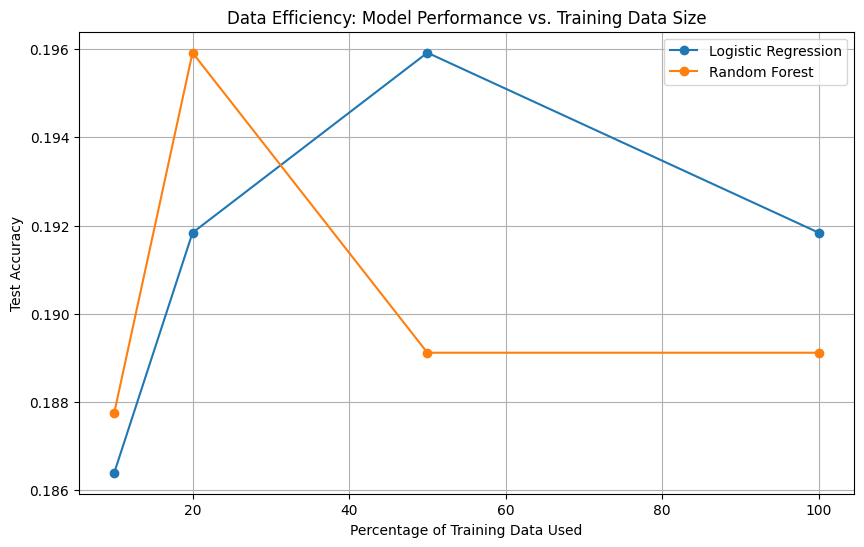

In [ ]:
# Example: Train on 10%, 20%, 50%, and 100% of the data
data_sizes = [0.1, 0.2, 0.5, 1.0]
logreg_accuracies = []
rf_accuracies = []

for size in data_sizes:
    if size == 1.0:
        # Use the full dataset
        X_train_sub = X_train_tfidf
        y_train_sub = y_train_encoded
    else:
        # Subset the data
        X_train_sub, _, y_train_sub, _ = train_test_split(X_train_tfidf, y_train_encoded, train_size=size, random_state=42)

    # Train models on the subset
    logreg.fit(X_train_sub, y_train_sub)
    rf.fit(X_train_sub, y_train_sub)

    # Predict and evaluate
    logreg_preds = logreg.predict(X_test_tfidf)
    rf_preds = rf.predict(X_test_tfidf)

    logreg_acc = accuracy_score(y_test_encoded, logreg_preds)
    rf_acc = accuracy_score(y_test_encoded, rf_preds)

    logreg_accuracies.append(logreg_acc)
    rf_accuracies.append(rf_acc)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot([int(100 * s) for s in data_sizes], logreg_accuracies, label='Logistic Regression', marker='o')
plt.plot([int(100 * s) for s in data_sizes], rf_accuracies, label='Random Forest', marker='o')
plt.title('Data Efficiency: Model Performance vs. Training Data Size')
plt.xlabel('Percentage of Training Data Used')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Varying the underlying model (rather than train/test split)

I decided to try updating the underlying model conditions for the random forest, which was equally unsuccessful in my efforts to gain some insight into this data set beyond the training data.

Random Forest Test Accuracy with 10 estimators: 0.19047619047619047
Random Forest Test Accuracy with 50 estimators: 0.19319727891156463
Random Forest Test Accuracy with 100 estimators: 0.1891156462585034
Random Forest Test Accuracy with 200 estimators: 0.19183673469387755
Random Forest Test Accuracy with 300 estimators: 0.18775510204081633
Random Forest Test Accuracy with 500 estimators: 0.19047619047619047


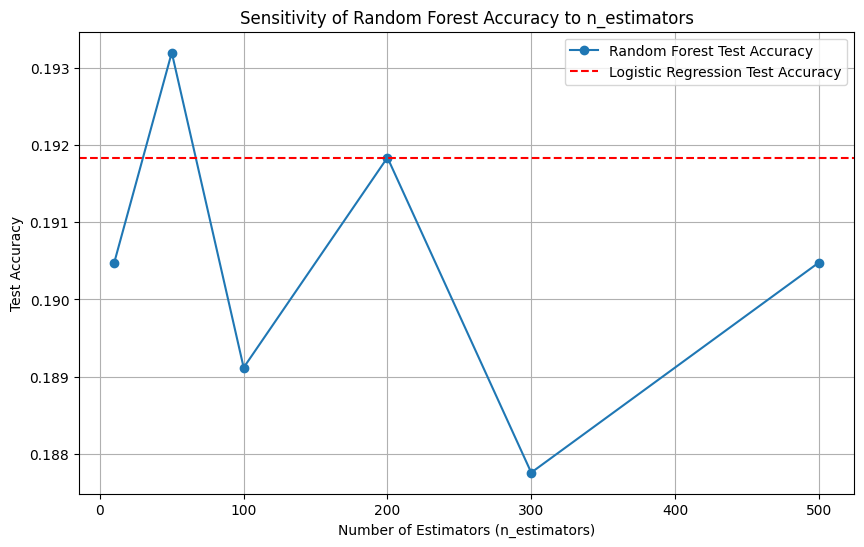

Logistic Regression Test Accuracy: 0.19183673469387755


In [ ]:
# Define a range of n_estimators to test
n_estimators_range = [10, 50, 100, 200, 300, 500]
rf_accuracies = []

# Perform sensitivity analysis on Random Forest's n_estimators
for n_estimators in n_estimators_range:
    rf = RandomForestClassifier(random_state=42, n_estimators=n_estimators)
    rf.fit(X_train_tfidf, y_train_encoded)
    rf_preds = rf.predict(X_test_tfidf)
    rf_accuracy = accuracy_score(y_test_encoded, rf_preds)
    rf_accuracies.append(rf_accuracy)
    print(f"Random Forest Test Accuracy with {n_estimators} estimators: {rf_accuracy}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, rf_accuracies, label='Random Forest Test Accuracy', marker='o')
plt.axhline(y=logreg_accuracy, color='r', linestyle='--', label='Logistic Regression Test Accuracy')
plt.title('Sensitivity of Random Forest Accuracy to n_estimators')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Print the Logistic Regression results for comparison
print(f"Logistic Regression Test Accuracy: {logreg_accuracy}")

### References



*   https://www.kaggle.com/c/learn-ai-bbc/data
*   https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification

*   https://www.kaggle.com/code/jieshends2020/matrix-factorization-97-acc-with-1-labels?scriptVersionId=165487232&cellId=18








#Part 2:

Limitation(s) of sklearn’s non-negative matrix factorization library. [20 pts]

1. Load the movie ratings data (as in the HW3-recommender-system) and use matrix factorization technique(s) and predict the missing ratings from the test data. Measure the RMSE. You should use sklearn library. [10 pts]


2. Discuss the results and why sklearn's non-negative matrix facorization library did not work well compared to simple baseline or similarity-based methods we’ve done in Module 3. Can you suggest a way(s) to fix it? [10 pts]

Discussion: The RMSE of 3.5 is very high, suggesting that this model is not successfully capturing the underlying essence of the data at all. I will discuss the difficulties of this approach in the next section.

In [ ]:
users_df = pd.read_csv('/content/users.csv')
movies_df = pd.read_csv('/content/movies.csv')
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# Pivot the training data to create a user-item matrix
user_movie_matrix = train_df.pivot(index='uID', columns='mID', values='rating')

# Replace NaNs with 0s for NMF
imputer = SimpleImputer(strategy='constant', fill_value=0)
user_movie_matrix_filled = imputer.fit_transform(user_movie_matrix)

# Apply Non-Negative Matrix Factorization
n_components = 20  #
nmf_model = NMF(n_components=n_components, random_state=42, max_iter=500)  # Increased iterations for better convergence
user_factors = nmf_model.fit_transform(user_movie_matrix_filled)
movie_factors = nmf_model.components_

# Reconstruct the full user-item matrix
user_movie_predicted = np.dot(user_factors, movie_factors)

# Predict missing ratings for the test data
predicted_ratings = []
actual_ratings = []

for row in test_df.itertuples():
    user_index = row.uID - 1
    movie_index = row.mID - 1

    if user_index < user_movie_predicted.shape[0] and movie_index < user_movie_predicted.shape[1]:
        predicted_rating = user_movie_predicted[user_index, movie_index]
        predicted_ratings.append(predicted_rating)
        actual_ratings.append(row.rating)
    else:
        # Handle unseen users/movies by skipping them (if this case exists)
        continue

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print(f'Root Mean Squared Error (RMSE) for NMF: {rmse}')

Root Mean Squared Error (RMSE) for NMF: 3.5069182133580874


## Discussion of Movie Ratings Results

To say the results of the movie ratings exercise were disappointing would be polite. An RMSE of 3.5 is extremely high and suggests that the model is not performing very well at all. This could be due to a number of reasons, including:



*   Non-linear relationships in the data (which NMF assumes)
*   Sparse data (so limited info to base predictions on)
*   Cold start for some movies/individuals

This could be improved by using collaborative filtering methods in conjunction with NMF rather using NMF as a replacement for these techniques. In addition, exploring better regularization and data imputation techniques could help improve this method.

In the end, the goal is not to apply a specific technique. The goal is to solve the problem using the best technique available. If NMF is not the best approach for this problem, so be it. The key is to make sure it is truly not the best approach, and not simply a reflection of my own inexperience at this.



